## Model Training ##

The second part of our project is about training models to estimate scoring and conceding probabilities, and deriving the action values from those.

First we will load the data. If you have not already you should run the 1_Loading_Data.ipynb file to retrieve the data and save it to a file, so that it can be loaded here.

In [83]:
import pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

df_model = pd.read_pickle("data/data_cleaned.pkl")

### Encoding ###

Some classification algorithms like logistic regression require us to encode categorical columns like action_type or body_part. So we will do this via one-hot encoding.

In [84]:
body_part_dummies = pd.get_dummies(df_model['body_part_name'], prefix='body_part_name')
action_type_dummies = pd.get_dummies(df_model['action_type'], prefix='action_type')

df_model = pd.concat([df_model, body_part_dummies, action_type_dummies], axis=1)

### Estimating Probabilities ###

#### Logistic Regression ####

Now we can train our first logistic regression model to try and predict the two labels based on our features.

In [85]:
features = ['distance_to_goal', 'angle_to_goal', 'time_elapsed', 'period']

target = 'label_team_goal'

df_model = df_model.dropna(subset=features + [target])

X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

y_prob_all = model.predict_proba(df_model[features])[:, 1]
df_model = df_model.copy()
df_model['predicted_goal_prob'] = y_prob_all

coefficients = model.coef_[0]

coeff_df = pd.DataFrame(coefficients, columns=["Coefficient"], index=features)
print(coeff_df)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     69831
           1       0.50      0.01      0.01       729

    accuracy                           0.99     70560
   macro avg       0.74      0.50      0.50     70560
weighted avg       0.98      0.99      0.98     70560

ROC AUC Score: 0.7799255066106199
                  Coefficient
distance_to_goal    -0.037381
angle_to_goal        0.037157
time_elapsed         0.000080
period               0.030149


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


And analogously the same for the conceding probabilities.

In [86]:
target_opponent = 'label_opponent_goal'

X_opp = df_model[features]
y_opp = df_model[target_opponent]

X_train_opp, X_test_opp, y_train_opp, y_test_opp = train_test_split(X_opp, y_opp, test_size=0.5, stratify=y_opp)

model_opp = LogisticRegression()
model_opp.fit(X_train_opp, y_train_opp)

y_pred_opp = model_opp.predict(X_test_opp)
y_prob_opp = model_opp.predict_proba(X_test_opp)[:, 1]

print("Classification Report (Conceding Goals):")
print(classification_report(y_test_opp, y_pred_opp))

print("ROC AUC Score (Conceding Goals):", roc_auc_score(y_test_opp, y_prob_opp))

y_prob_all_opp = model_opp.predict_proba(df_model[features])[:, 1]
df_model = df_model.copy()
df_model['predicted_concede_prob'] = y_prob_all_opp

coefficients_opp = model_opp.coef_[0]
coeff_opp_df = pd.DataFrame(coefficients_opp, index=features, columns=["Coefficient"])
print(coeff_opp_df)

Classification Report (Conceding Goals):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70428
           1       0.00      0.00      0.00       132

    accuracy                           1.00     70560
   macro avg       0.50      0.50      0.50     70560
weighted avg       1.00      1.00      1.00     70560

ROC AUC Score (Conceding Goals): 0.7033839416485523
                  Coefficient
distance_to_goal     0.028974
angle_to_goal        0.019011
time_elapsed         0.000094
period              -0.045433


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

#### XGBoost ####

Since some of the features are non-linear, XGBoost will probably perform better.

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     69831
           1       1.00      0.01      0.01       729

    accuracy                           0.99     70560
   macro avg       0.99      0.50      0.50     70560
weighted avg       0.99      0.99      0.98     70560

ROC AUC Score: 0.8182000993619732


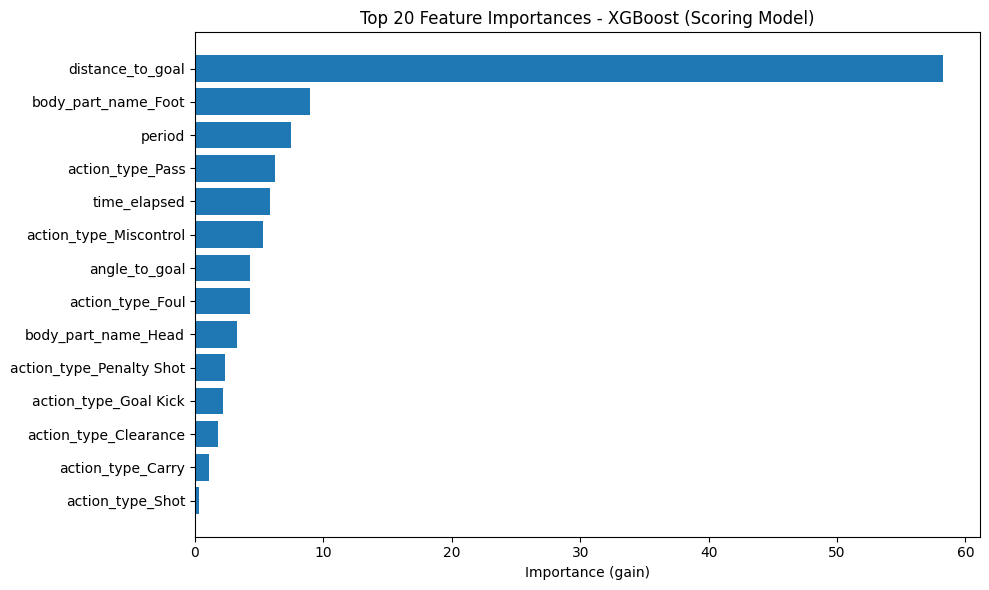

In [87]:
features = ['distance_to_goal', 'angle_to_goal', 'time_elapsed', 'period',
        'body_part_name_Foot', 'body_part_name_Head', 'body_part_name_Other',
        'action_type_Ball Recovery', 'action_type_Carry',
        'action_type_Clearance', 'action_type_Corner', 'action_type_Foul',
        'action_type_Free Kick Pass', 'action_type_Free Kick Shot',
        'action_type_Goal Kick', 'action_type_Interception',
        'action_type_Miscontrol', 'action_type_Own Goal', 'action_type_Pass',
        'action_type_Penalty Shot', 'action_type_Shot', 'action_type_Tackle',
        'action_type_Throw In',]

df_model = df_model.dropna(subset=features + [target])

X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

y_prob_all = xgb_model.predict_proba(df_model[features])[:, 1]
df_model = df_model.copy()
df_model['predicted_goal_prob'] = y_prob_all

importance_dict = xgb_model.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['importance'])
importance_df = importance_df.reset_index().rename(columns={'index': 'feature'})
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'][:20][::-1], importance_df['importance'][:20][::-1])
plt.xlabel('Importance (gain)')
plt.title('Top 20 Feature Importances - XGBoost (Scoring Model)')
plt.tight_layout()
plt.show()

And analogously for the conceding probabilities.

In [88]:
df_model = df_model.dropna(subset=features + [target_opponent])

X_opp = df_model[features]
y_opp = df_model[target_opponent]

X_train_opp, X_test_opp, y_train_opp, y_test_opp = train_test_split(
    X_opp, y_opp, test_size=0.5, stratify=y_opp
)

model_opp = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)

model_opp.fit(X_train_opp, y_train_opp)

y_pred_opp = model_opp.predict(X_test_opp)
y_prob_opp = model_opp.predict_proba(X_test_opp)[:, 1]

print("Classification Report (Conceding Goals):")
print(classification_report(y_test_opp, y_pred_opp))
print("ROC AUC Score (Conceding Goals):", roc_auc_score(y_test_opp, y_prob_opp))

df_model = df_model.copy()
df_model['predicted_concede_prob'] = model_opp.predict_proba(X_opp)[:, 1]

Classification Report (Conceding Goals):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70428
           1       0.00      0.00      0.00       132

    accuracy                           1.00     70560
   macro avg       0.50      0.50      0.50     70560
weighted avg       1.00      1.00      1.00     70560

ROC AUC Score (Conceding Goals): 0.8170398825535987


### Computing Action Values ###

Now we can calculate the action value as the sum of differences in scoring and conceding probabilities between subsequent game states. We need to consider two special cases though:

1. When a shot ends up in a goal the next state value will be set to 1. Works analogously for an own goal.
2. When possession changes after an action, the probabilities are switched in the next state, because the scoring and conceding probabilities always        correspond to the team performing the action.

In [89]:
df_model['action_value'] = 0.0

for match_id, df_match in df_model.groupby('match_id', sort=False):
    idxs = df_match.index.to_list()

    for i in range(len(idxs) - 1):
        idx_current = idxs[i]
        idx_next = idxs[i + 1]

        current_team = df_model.at[idx_current, 'team_id']
        next_team = df_model.at[idx_next, 'team_id']

        score_curr = df_model.at[idx_current, 'predicted_goal_prob']
        concede_curr = df_model.at[idx_current, 'predicted_concede_prob']

        score_next = df_model.at[idx_next, 'predicted_goal_prob']
        concede_next = df_model.at[idx_next, 'predicted_concede_prob']

        goal_scored = (
            df_model.at[idx_current, 'type_name'] == 'Shot' and
            df_model.at[idx_current, 'outcome_name'] == 'Goal'
        )

        own_goal_scored = (
            df_model.at[idx_current, 'type_name'] == 'Own Goal Against'
        )

        if goal_scored:
            score_next = 1.0
            concede_next = 0.0
        elif own_goal_scored:
            score_next = 0.0
            concede_next = 1.0

        if next_team != current_team and not goal_scored and not own_goal_scored:
            score_next, concede_next = concede_next, score_next

        delta_score = score_next - score_curr
        delta_concede = concede_curr - concede_next
        action_value = delta_score + delta_concede

        df_model.at[idx_current, 'action_value'] = action_value

In [90]:
test = df_model[['id', 'match_id', 'timestamp', 'period', 'x', 'y', 'distance_to_goal', 'angle_to_goal', 'player_name', 'possession_team_name', 'team_name',
     'type_name', 'play_pattern_name', 'outcome_name', 'label_team_goal', 'label_opponent_goal', 'predicted_goal_prob', 'predicted_concede_prob',
     'body_part_name', 'action_type', 'sub_type_name', 'result', 'action_value']]

df_model[
    ['id', 'match_id', 'timestamp', 'x', 'y', 'distance_to_goal', 'angle_to_goal', 'player_name', 'possession_team_name', 'team_name',
     'type_name', 'play_pattern_name', 'outcome_name', 'label_team_goal', 'label_opponent_goal', 'predicted_goal_prob', 'predicted_concede_prob',
     'body_part_name', 'action_type', 'sub_type_name', 'result', 'action_value']
].to_csv("data/data.csv", index=False)

df_model.to_pickle("data/data_cleaned_trained.pkl")

We can now rank players according to their cumulated action values.

In [91]:
top_players_df = df_model.groupby(['player_id', 'player_name'])['action_value'].sum().reset_index()
top_players_df = top_players_df.sort_values(by='action_value', ascending=False)
print(top_players_df.head(30))

     player_id                              player_name  action_value
6       3009.0                     Kylian Mbappé Lottin      5.876300
160     5503.0           Lionel Andrés Messi Cuccittini      3.673353
422    20750.0                        Cody Mathès Gakpo      3.369564
116     5204.0            Bruno Miguel Borges Fernandes      2.676039
436    22084.0                              Bukayo Saka      2.499656
296     8361.0                               Ritsu Doan      2.292091
158     5487.0                        Antoine Griezmann      2.239920
245     6704.0          Theo Bernard François Hernández      2.176726
412    18395.0  Vinícius José Paixão de Oliveira Júnior      2.067989
507    29560.0                           Julián Álvarez      2.005961
5       2995.0          Ángel Fabián Di María Hernández      1.871899
504    29163.0                          Josip Juranović      1.870355
339    11174.0                   Vincent Paté Aboubakar      1.803416
40      3318.0      

TODO:
1. paper checken target variable
2. minuten zusammenrechnen
3. feld visualisierung
4. enhanced features (pressure, goalkeeper position)
5. synchronisierung event data + frames
6. modelle testen + ausprobieren
7. Beispiele aussuchen